Import & Setting

In [1]:
!pip install psycopg2-binary

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import psycopg2
# Replace with your actual PostgreSQL credentials
conn = psycopg2.connect(
dbname='final_project',
user='postgres',
password='900408',
host='localhost',
port='5432'
)
cur = conn.cursor()
print("✅ Connected to the database!")

✅ Connected to the database!


In [53]:
cur.execute("""
    CREATE TABLE IF NOT EXISTS salaries (
        work_year INTEGER,
        experience_level TEXT,
        employment_type TEXT,
        job_title TEXT,
        salary INTEGER,
        salary_currency TEXT,
        salary_in_usd INTEGER,
        employee_residence TEXT,
        remote_ratio INTEGER,
        company_location TEXT,
        company_size TEXT
);
""")

conn.commit()
print("✅ Table created!")

✅ Table created!


---

Question 11 : Remote Work Trends

What proportion is remote? Identify which company sizes offer more remote work.

In [440]:
cur.execute("SELECT company_size, remote_ratio, COUNT(salaries) FROM salaries  GROUP BY company_size, remote_ratio ORDER BY company_size, remote_ratio DESC;")
rows = cur.fetchall()
df = pd.DataFrame(rows, columns=['company_size', 'remote_ratio', 'count'])
print(df)

  company_size  remote_ratio  count
0            L           100    357
1            L            50    192
2            L             0   2154
3            M           100  18232
4            M            50     62
5            M             0  67373
6            S           100    119
7            S            50     42
8            S             0     53


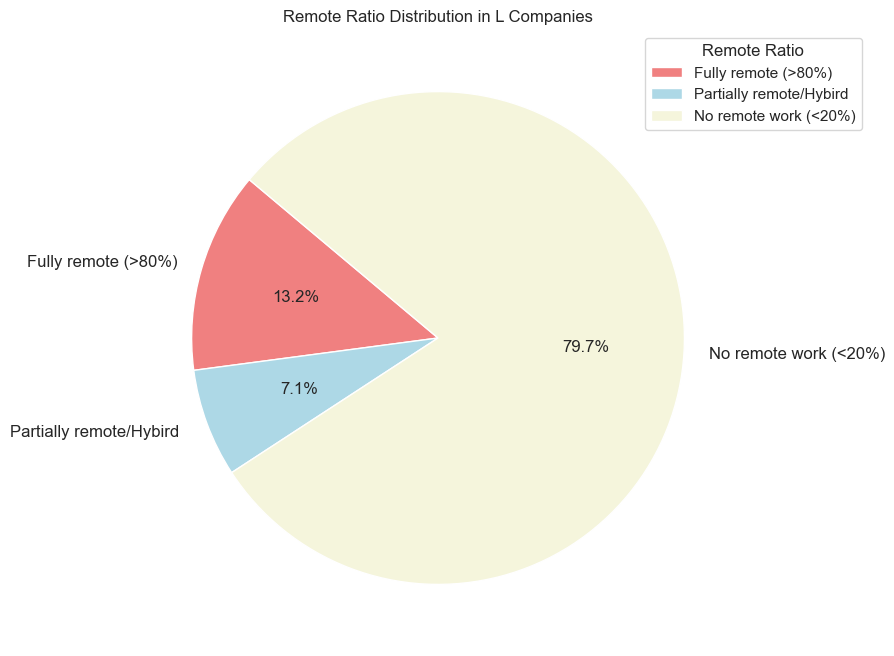

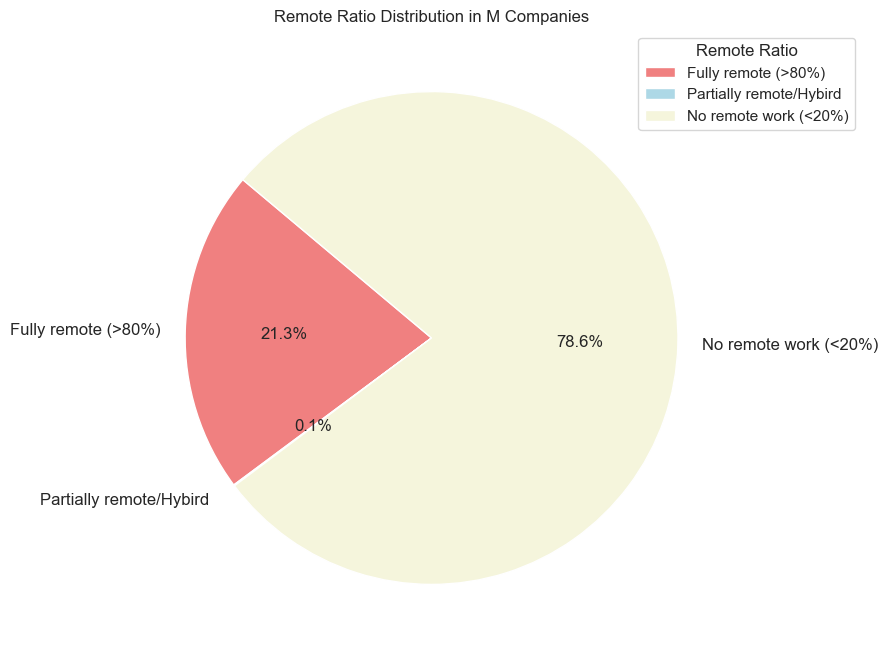

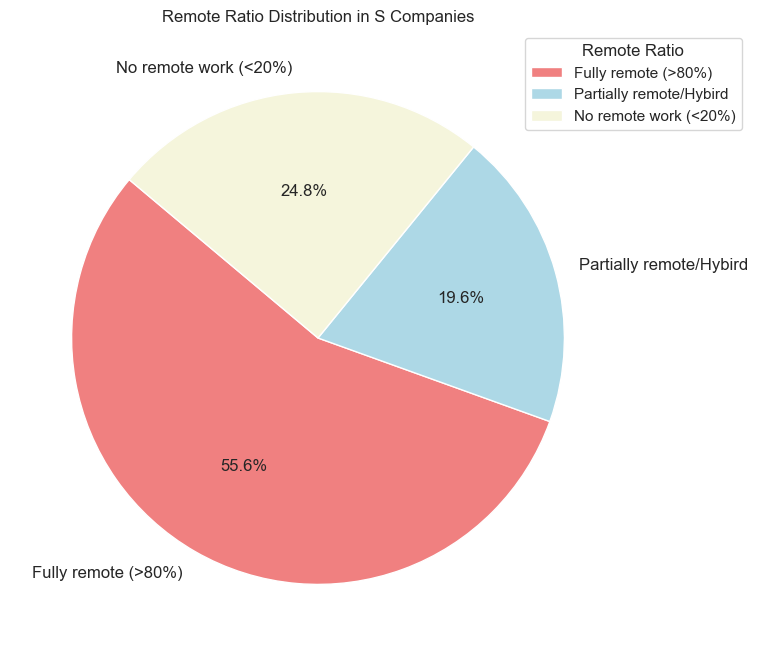

In [446]:
remote_ratio_labels = {
    0: "No remote work (<20%)",
    50: "Partially remote/Hybird ",
    100: "Fully remote (>80%)"
}

company_sizes = df['company_size'].unique()

for size in company_sizes:
    df_filtered = df[df['company_size'] == size]
    
    plt.figure(figsize=(8, 8))
    wedges, texts, autotexts = plt.pie(
        df_filtered['count'], 
        labels = [remote_ratio_labels[r] for r in df_filtered['remote_ratio']],
        autopct = '%1.1f%%', 
        colors = ['lightcoral', 'lightblue', 'beige'], 
        startangle = 140,
        textprops = {'fontsize': 12}
    )
    
    plt.legend(wedges, 
               [remote_ratio_labels[r] for r in df_filtered['remote_ratio']],
               title = "Remote Ratio",
               loc = "upper right",
               bbox_to_anchor = (1.2, 1),
              ncol = 1)
    
    plt.title(f'Remote Ratio Distribution in {size} Companies')
    plt.show()

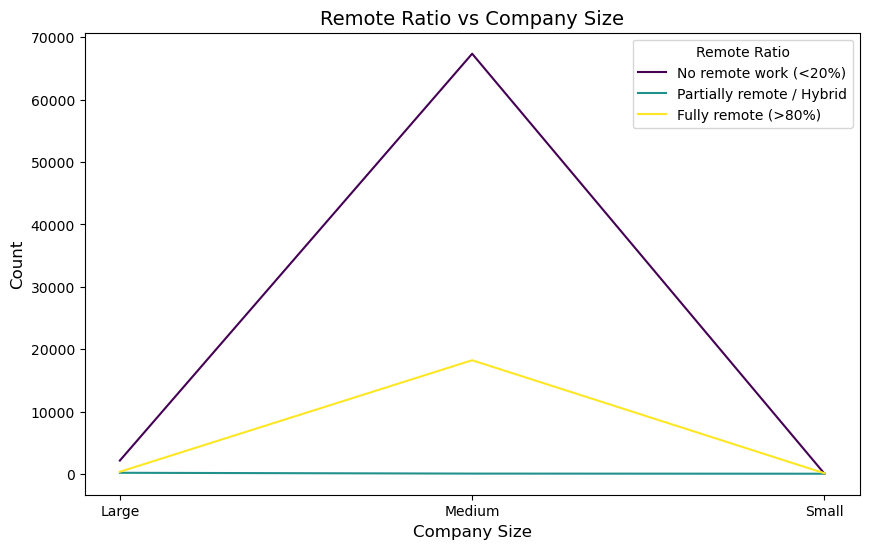

In [215]:
plt.figure(figsize=(10,6))

sns.lineplot(data=df, x='company_size', y='count', hue='remote_ratio', palette='viridis')

plt.xticks(
    ['S', 'M', 'L'],
    labels=['Small', 'Medium', 'Large']
)

plt.title('Remote Ratio vs Company Size', fontsize=14)
plt.xlabel('Company Size', fontsize=12)
plt.ylabel('Count', fontsize=12)

legend_labels = {
    0: "No remote work (<20%)",
    50: "Partially remote / Hybrid",
    100: "Fully remote (>80%)"
}

handles, labels = plt.gca().get_legend_handles_labels()

new_labels = [legend_labels.get(int(label), label) for label in labels]
plt.legend(handles, new_labels, title='Remote Ratio')

plt.show()

From these two charts, we can see that if you want to work remotely, you have a high chance of getting a remote job when all your interview opportunities are with small companies.

However, in terms of quantity, there are more remote opportunities available in medium-sized companies.

---

Q12 : Best Paying Job Titles

List top-paying job titles.

In [300]:
df.loc[(df['experience_level'] == 'MI') & (df['job_title'] == 'Engineering Manager'), 'job_title'] = 'Engineering Manager(MI)'
print(df.loc[(df['experience_level'] == 'MI') & (df['job_title'] == 'Engineering Manager(MI)')])

    experience_level                job_title           avg_salary  count
232               MI  Engineering Manager(MI)  264678.948387096774    310


In [478]:
cur.execute("SELECT experience_level, job_title, AVG(salary_in_usd), COUNT(job_title) FROM salaries GROUP BY experience_level, job_title ORDER BY CASE WHEN experience_level = 'EN' THEN 1 WHEN experience_level = 'MI' THEN 2 WHEN experience_level = 'SE' THEN 3 WHEN experience_level = 'EX' THEN 4 END, AVG(salary_in_usd) DESC;")
rows = cur.fetchall()
df = pd.DataFrame(rows, columns=['experience_level', 'job_title', 'avg_salary', 'count'])

df['experience_level'] = df['experience_level'].str.strip()
df['job_title'] = df['job_title'].str.strip()

df.loc[(df['experience_level'] == 'MI') & (df['job_title'] == 'Engineering Manager'), 'job_title'] = 'Engineering Manager(MI)'

top_3_per_level = df.groupby('experience_level').head(3)

print(top_3_per_level)

    experience_level                      job_title           avg_salary  \
0                 EN                   Head of Data  240500.000000000000   
1                 EN            Engineering Manager  217800.000000000000   
2                 EN             Research Scientist  193336.691449814126   
152               MI                   AI Architect  800000.000000000000   
153               MI        Engineering Manager(MI)  264678.948387096774   
154               MI             AWS Data Architect  258000.000000000000   
370               SE  Analytics Engineering Manager  399880.000000000000   
371               SE         Data Science Tech Lead  375000.000000000000   
372               SE             Applied AI ML Lead  292500.000000000000   
630               EX       Principal Data Scientist  416000.000000000000   
631               EX       Head of Machine Learning  283573.545454545455   
632               EX                   AI Developer  276000.000000000000   

     count 

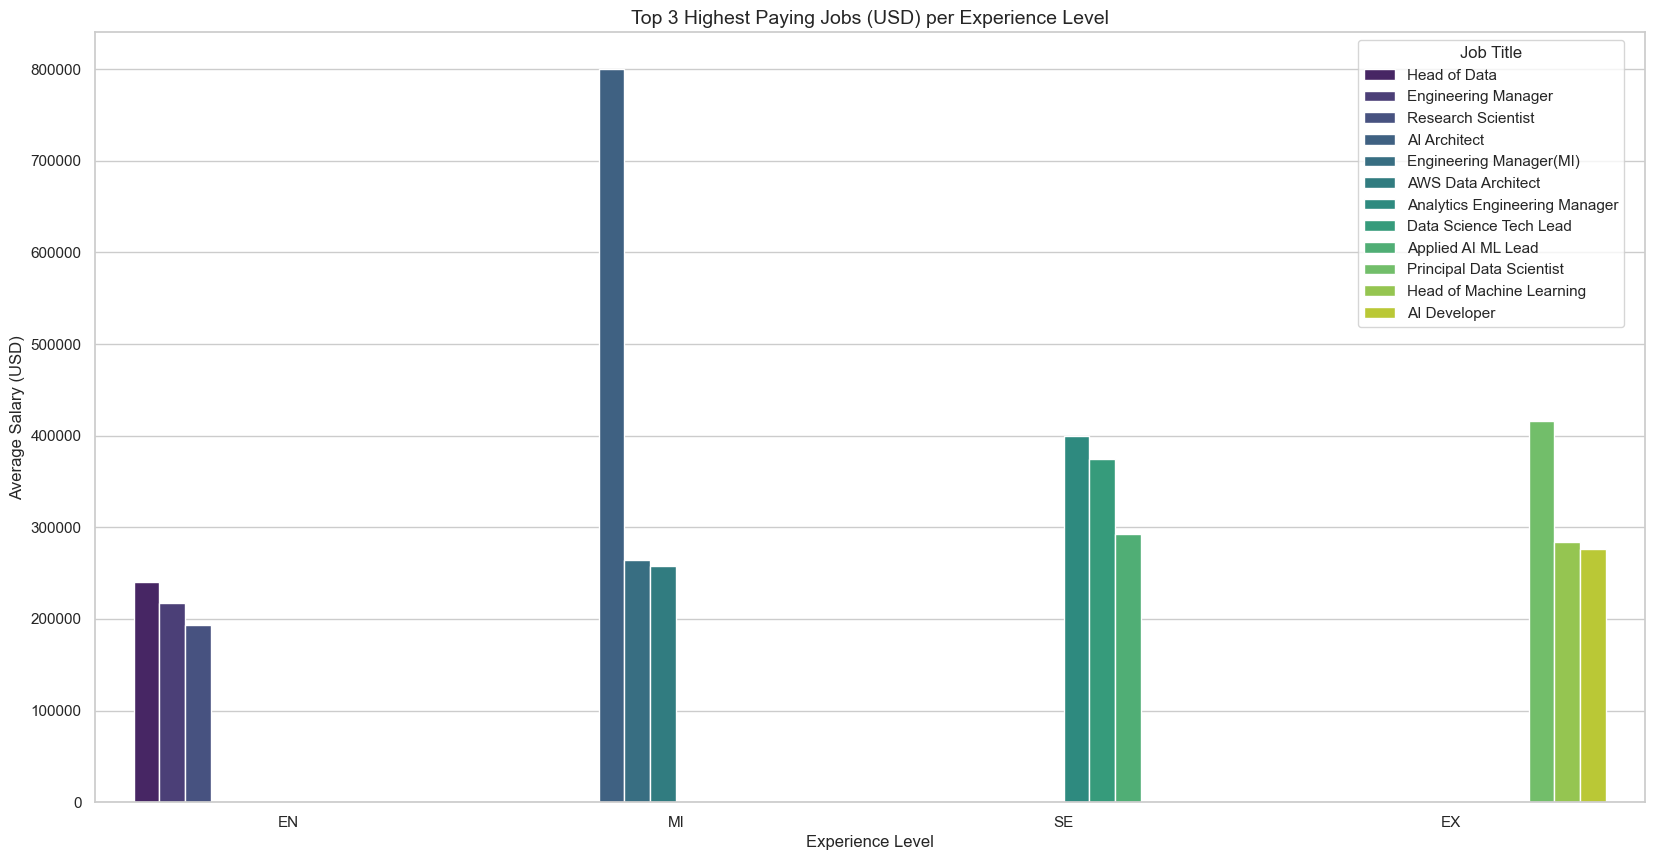

In [462]:
sns.set_theme(style = "whitegrid")

plt.figure(figsize = (20, 10))

sns.barplot(data = top_3_per_level, x = 'experience_level', y = 'avg_salary', hue = 'job_title', palette = 'viridis')

plt.title('Top 3 Highest Paying Jobs (USD) per Experience Level', fontsize = 14)
plt.xlabel('Experience Level', fontsize = 12)
plt.ylabel('Average Salary (USD)', fontsize = 12)
plt.legend(title = 'Job Title', bbox_to_anchor = (0.81,1),loc = 'upper left')

plt.show()

---

Q13 : Experience Level & Work Type Distribution.

See how experience level correlates with employment type.

In [480]:
cur.execute("SELECT experience_level, employment_type, AVG(salary_in_usd) AS avg_salary, COUNT(employment_type) AS employment_type_count FROM salaries  GROUP BY experience_level, employment_type ORDER BY CASE WHEN experience_level = 'EN' THEN 1 WHEN experience_level = 'MI' THEN 2 WHEN experience_level = 'SE' THEN 3 WHEN experience_level = 'EX' THEN 4 END, avg_salary DESC;")
rows = cur.fetchall()
df = pd.DataFrame(rows, columns=['experience_level', 'employment_type', 'avg_salary', 'employment_type_count'])
print(df)

   experience_level employment_type           avg_salary  \
0                EN              FT  101235.161480029405   
1                EN              PT   68571.121428571429   
2                EN              CT   61705.960000000000   
3                EN              FL   60000.000000000000   
4                MI              FT  143003.602872072478   
5                MI              CT  107892.805194805195   
6                MI              PT   71499.171875000000   
7                MI              FL   42179.666666666667   
8                SE              FT  173152.852695564360   
9                SE              PT  122075.068965517241   
10               SE              CT  115943.956521739130   
11               SE              FL   52891.166666666667   
12               EX              FT  200239.627155172414   
13               EX              CT  190618.666666666667   

    employment_type_count  
0                    8162  
1                     140  
2              

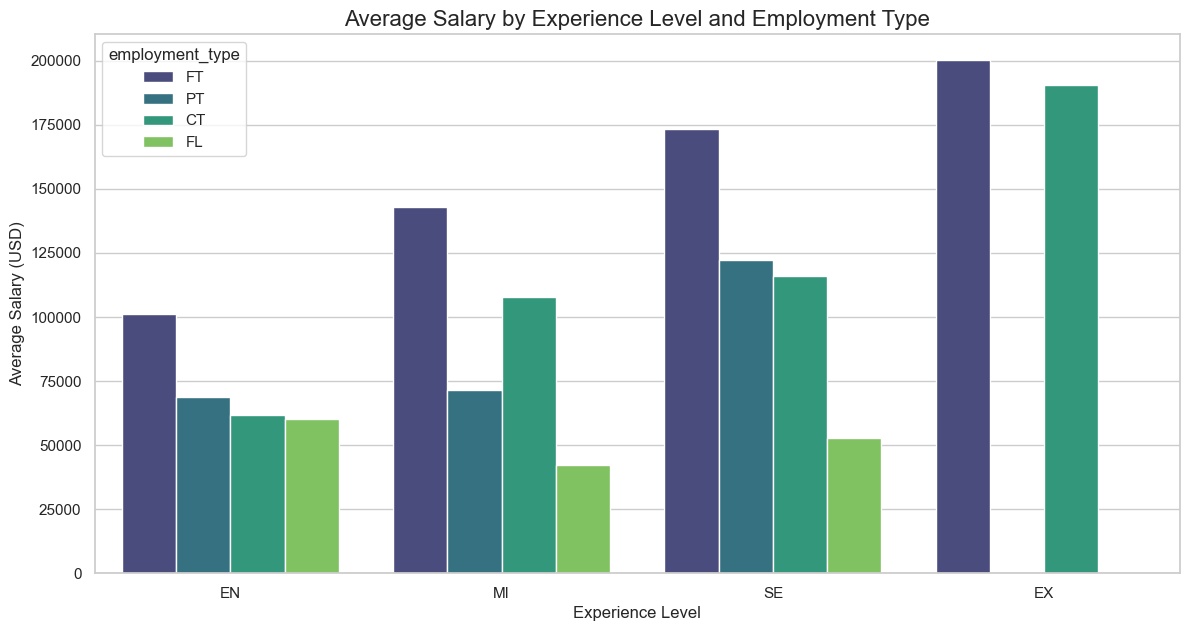

In [482]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(14, 7))

sns.barplot(data=df, x='experience_level', y='avg_salary', hue='employment_type', palette='viridis')

plt.title('Average Salary by Experience Level and Employment Type', fontsize=16)
plt.xlabel('Experience Level', fontsize=12)
plt.ylabel('Average Salary (USD)', fontsize=12)

plt.show()

---

Q14 : Industry Growth Trends.

Check if the number of job positions is growing over the years.

In [516]:
cur.execute("SELECT work_year, COUNT(*) AS count_job FROM salaries GROUP BY work_year ORDER BY work_year DESC;")
rows = cur.fetchall()
df = pd.DataFrame(rows, columns=['work_year', 'count_job'])
print(df)

   work_year  count_job
0       2025      15875
1       2024      62234
2       2023       8522
3       2022       1660
4       2021        218
5       2020         75


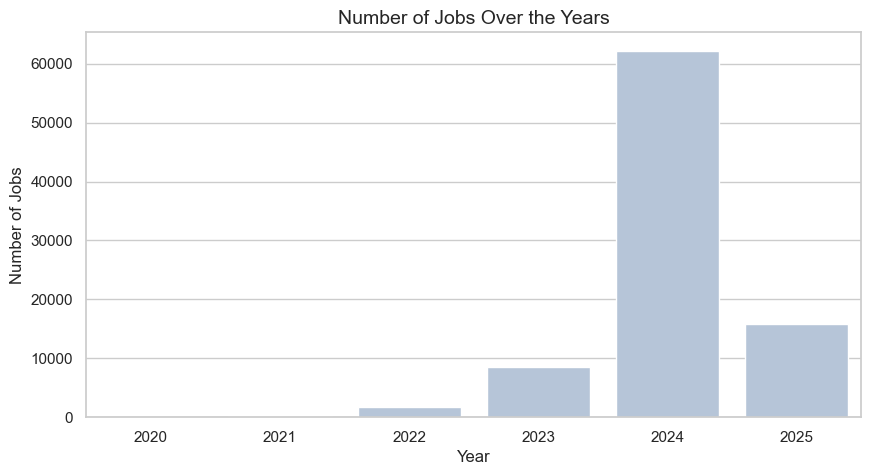

In [524]:
sns.set_theme(style="whitegrid")

# 設定圖形大小
plt.figure(figsize=(10, 5))

# 繪製長條圖
sns.barplot(data=df, x='work_year', y='count_job', color='lightsteelblue')

# 添加標題 & 標籤
plt.title("Number of Jobs Over the Years", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Jobs", fontsize=12)

# 顯示圖表
plt.show()

In [484]:
cur.execute("SELECT experience_level, work_year, COUNT(*) AS count_job FROM salaries GROUP BY work_year, experience_level ORDER BY CASE WHEN experience_level = 'EN' THEN 1 WHEN experience_level = 'MI' THEN 2 WHEN experience_level = 'SE' THEN 3 WHEN experience_level = 'EX' THEN 4 END, work_year DESC;")
rows = cur.fetchall()
df = pd.DataFrame(rows, columns=['experience_level', 'work_year', 'count_job'])
print(df)

   experience_level  work_year  count_job
0                EN       2025       1549
1                EN       2024       6183
2                EN       2023        465
3                EN       2022        117
4                EN       2021         46
5                EN       2020         21
6                MI       2025       5023
7                MI       2024      19531
8                MI       2023       1717
9                MI       2022        359
10               MI       2021         87
11               MI       2020         31
12               SE       2025       8935
13               SE       2024      35329
14               SE       2023       6097
15               SE       2022       1141
16               SE       2021         75
17               SE       2020         19
18               EX       2025        368
19               EX       2024       1191
20               EX       2023        243
21               EX       2022         43
22               EX       2021    

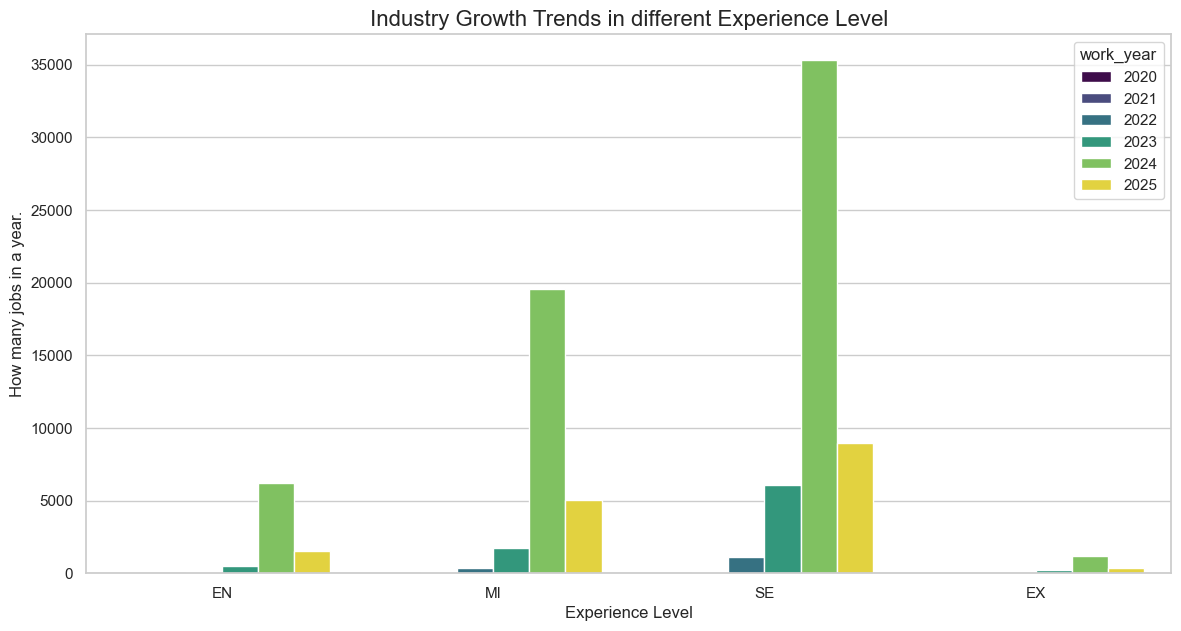

In [486]:
sns.set_theme(style = "whitegrid")

plt.figure(figsize = (14, 7))

sns.barplot(data = df, x = 'experience_level', y = 'count_job', hue = 'work_year', palette = 'viridis')

plt.title('Industry Growth Trends in different Experience Level', fontsize = 16)
plt.xlabel('Experience Level', fontsize = 12)
plt.ylabel('How many jobs in a year.', fontsize = 12)

plt.show()

In [402]:
cur.execute("SELECT employment_type, work_year, COUNT(*) AS count_job FROM salaries GROUP BY work_year, employment_type ORDER BY employment_type, work_year DESC;")
rows = cur.fetchall()
df = pd.DataFrame(rows, columns=['employment_type', 'work_year', 'count_job'])
print(df)

   employment_type  work_year  count_job
0               CT       2025         75
1               CT       2024        129
2               CT       2023         10
3               CT       2022          4
4               CT       2021          3
5               CT       2020          3
6               FL       2024          4
7               FL       2023          4
8               FL       2022          4
9               FL       2021          3
10              FL       2020          1
11              FT       2025      15742
12              FT       2024      61941
13              FT       2023       8505
14              FT       2022       1646
15              FT       2021        208
16              FT       2020         69
17              PT       2025         58
18              PT       2024        160
19              PT       2023          3
20              PT       2022          6
21              PT       2021          4
22              PT       2020          2


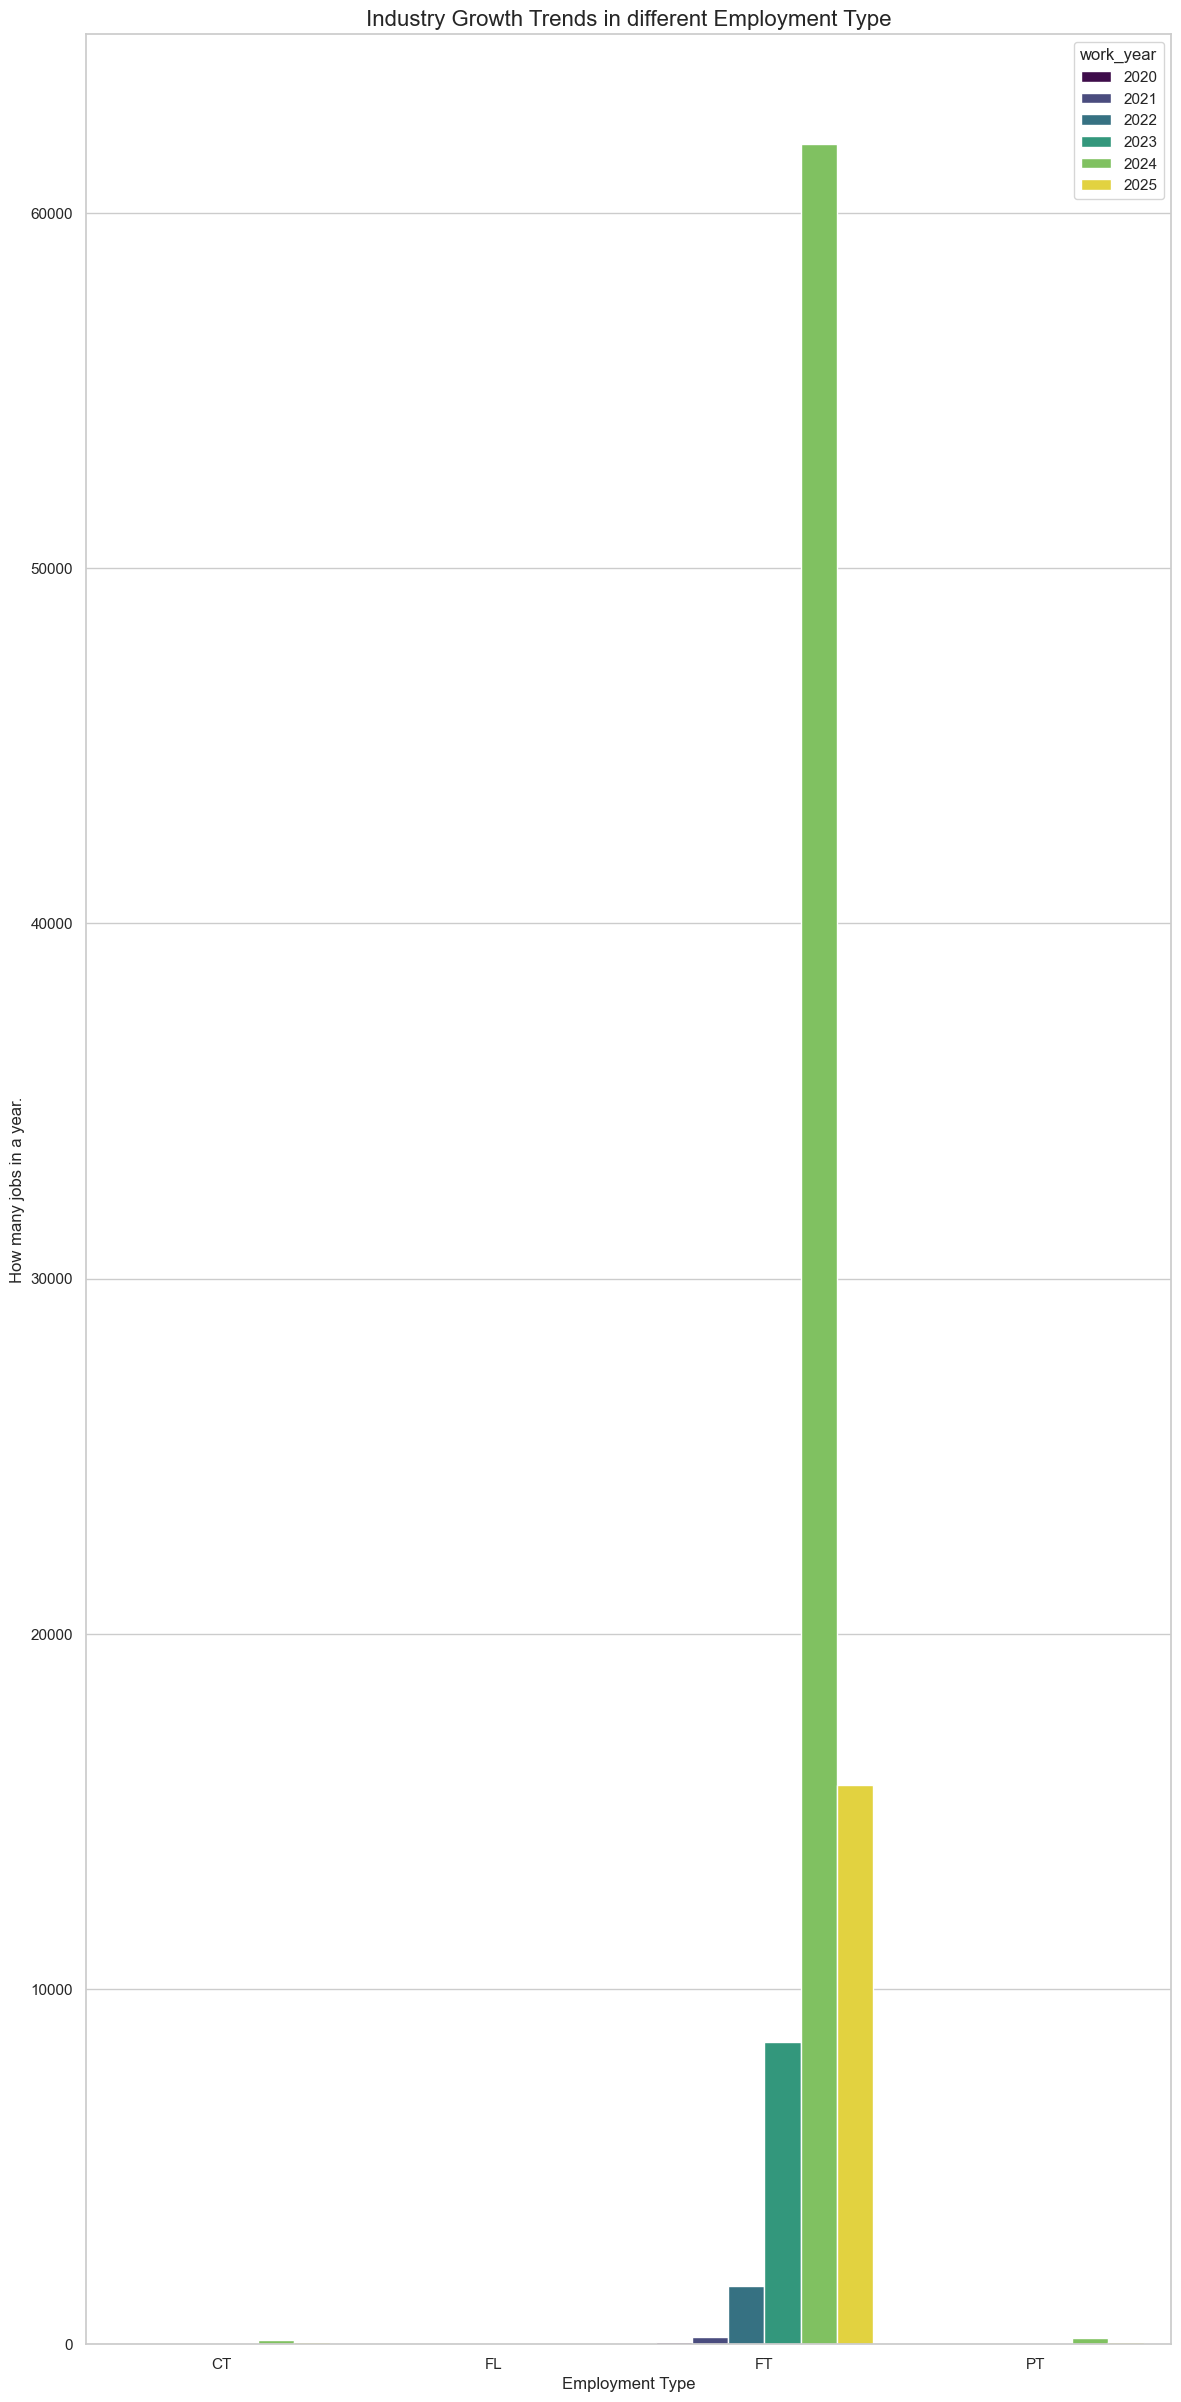

In [406]:
sns.set_theme(style = "whitegrid")

plt.figure(figsize = (14, 30))

sns.barplot(data = df, x = 'employment_type', y = 'count_job', hue = 'work_year', palette = 'viridis')

plt.title('Industry Growth Trends in different Employment Type', fontsize = 16)
plt.xlabel('Employment Type', fontsize = 12)
plt.ylabel('How many jobs in a year.', fontsize = 12)

plt.show()